In [1]:
import numpy as np
def source_function( x, y ):
    if ( x >= 0.1 and x <= 0.3 and y >= 0.1 and y <= 0.3 ):
        return 1.0
    else:
        return 0.0

np_source_function = np.vectorize(source_function)

In [2]:
# Finds the index k = 0,1,2,...,N-1 in the vector corresponding to the grid
# point (x_i, y_j) where i,j = 0,1,2,...,n-1

def indexFD(i, j, n):
  k = ( i*n + j )
  return k

def reverseIndexFD(k, n):
    i = k // n
    j = k % n
    return i, j

In [3]:
import numpy as np

def boundaryConditions(n):

  extNodes = []

  # Find nodes at the boundary of the square
  for j in range(0,n):
    extNodes.append( indexFD(j,0,n) )
    extNodes.append( indexFD(j,n-1,n) )
    extNodes.append( indexFD(0,j,n) )
    extNodes.append( indexFD(n-1,j,n) )

  extNodes = np.unique(extNodes)
  intNodes = np.setdiff1d(np.arange(0,n**2), extNodes);

  return intNodes, extNodes

In [4]:
import scipy as sp
import numpy as np

def diffusionMatrix( mux, muy, h ):
  n = int(1./h + 1)
  N = n**2
  A = sp.sparse.lil_array((N, N), dtype=np.float64)

  # Pass through all grid points and apply local stencil

  stencil = np.array([(mux+muy)*2., -mux*1., -mux*1., -muy*1., -muy*1.]) / h**2

  # Loop over each internal node in the grid, i,j = 1,2,...,n-2
  for i in range(1,n-1):
    for j in range(1,n-1):
      # Find k-indices of the four neighbouring nodes
      localStencilIndices = np.array([indexFD(i,j,n), indexFD(i+1,j,n), indexFD(i-1,j,n), indexFD(i,j+1,n), indexFD(i,j-1,n)])

      # Add the local stencil for node (x_i,y_j) to the matrix
      currentRow = indexFD(i,j,n)
      for m in range (0,5):
        A[currentRow, localStencilIndices[m]] = A[currentRow, localStencilIndices[m]] + stencil[m]

  # After the matrix A has been assembled, we convert it to the column-major format
  # for more efficient computations
  A = A.tocsc()

  return (A)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [48]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.sparse.linalg import norm

def diffusionGradSolver( mux, muy, h, tol, maxiter, M ):
  n = int(1./h + 1)  # dimension of spatial mesh in each dimension
  N = n**2
  f = sp.sparse.csc_array((N, 1), dtype=np.float64)

  F = np.zeros((N, 1), dtype=np.float64)
  intNodes, extNodes = boundaryConditions(n)
  
  # Placeholder for an initial guess
  u0 = np.zeros((N, 1))

  # Evaluate the source function
  for k in range (0,N):
    i, j = reverseIndexFD(k, n)
    F[k] = source_function( i*h, j*h )
  
  # Assemble the diffusion matrix
  A = diffusionMatrix(mux, muy, h)
  A_int = A[intNodes][:, intNodes]
  F_int = F[intNodes]
  u0_int = u0[intNodes]

  # We plot the sparsity pattern of the matrix A to check that it has been
  # correctly assembled.
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(A.toarray(), vmin=-4./h*mux, vmax=4./h*mux, cmap='coolwarm')
  plt.title("Sparsity pattern")
  fig.colorbar(cax)
  plt.show()


  def iterate_count(x):
    iterate_count.iterate_counts += 1

  iterate_count.iterate_counts = 0

  f[intNodes], info = sp.sparse.linalg.cg(A_int, F_int, x0=None, tol=tol, maxiter=maxiter, M=M, callback=iterate_count, atol=None)
  print(f'Exit code: {info}')
  print(f'NUmber of iterations: {iterate_count.iterate_counts}')

  f[extNodes] = u0[extNodes]
  
  return f.toarray()


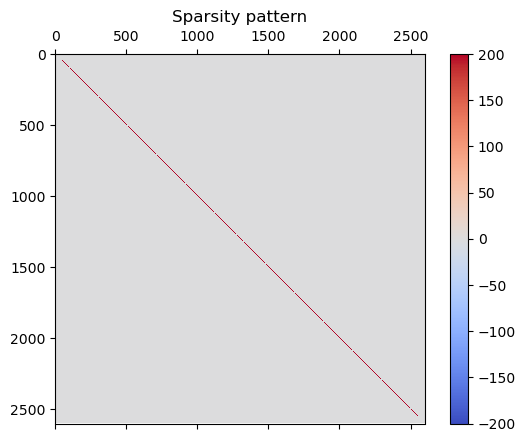

Exit code: 0
NUmber of iterations: 133


In [49]:
h = 0.02
mux = 1
muy = 1
solgrad = diffusionGradSolver(mux, muy, h, 1e-6, 1000, None)

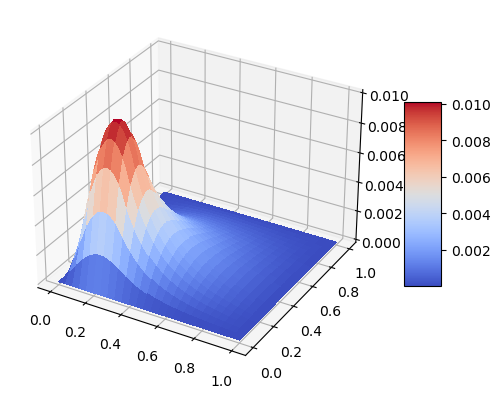

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z = solgrad.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.0, 0.01)


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

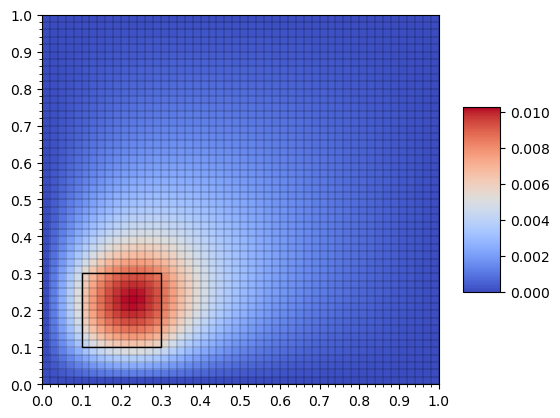

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches

fig, ax = plt.subplots()

# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z = solgrad.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf = ax.pcolor(X, Y, Z[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Create a Rectangle patch
rect = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
hx = 0.1
# Add a grid
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
plt.minorticks_on()
plt.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
major_ticks = np.arange(0., 1.+hx, hx)
minor_ticks = np.arange(0., 1.+hx, hx/5)

plt.xticks(major_ticks)
plt.yticks(major_ticks)
plt.show()

(d) incomplete-LU preconditioner

In [28]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.sparse.linalg import norm

h = 0.02
mux = 1
muy = 1
droptol = 0.1

intNodes, extNodes = boundaryConditions(int(1./h+1))

#Preconditioner matrix
MA = diffusionMatrix(mux, muy, h)
MA = MA.todense()
MA_intNodes = MA[intNodes][:, intNodes]
M = sp.sparse.linalg.spilu(MA_intNodes, drop_tol=droptol)
L = M.L
U = M.U

M2 = L@U
M2 = M2.toarray()

M_linear_operator = sp.sparse.linalg.LinearOperator(MA_intNodes.shape, lambda x: M.solve(x))


/usr/lib/python3/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:411: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


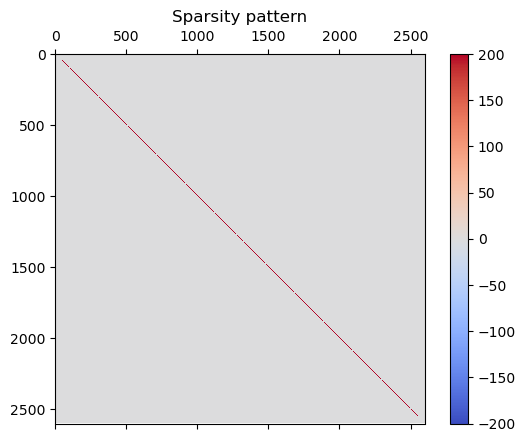

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
I

KeyboardInterrupt: 

In [29]:
solgrad2 = diffusionGradSolver(mux, muy, h, 1e-6, 10000, M2)

ValueError: cannot reshape array of size 2601 into shape (101,101)

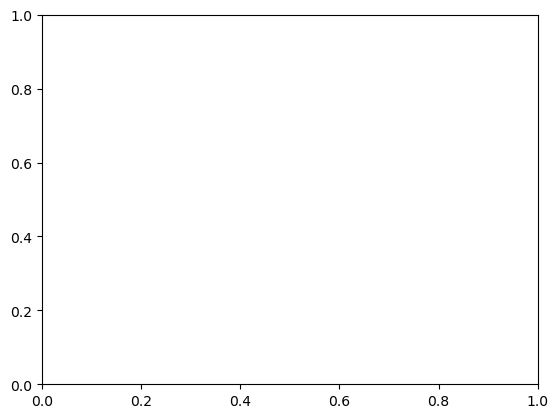

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches

fig, ax = plt.subplots()
hx = 0.1
# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z = solgrad2.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf = ax.pcolor(X, Y, Z[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Create a Rectangle patch
rect = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
hx = 0.1
# Add a grid
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.5)
major_ticks = np.arange(0., 1.+hx, hx)
minor_ticks = np.arange(0., 1.+hx, hx)

plt.xticks(major_ticks)
plt.yticks(major_ticks)

plt.show()

(d) My PCG

In [52]:
import scipy as sp
import numpy as np
from scipy.sparse.linalg import norm

def myPCG( A, b, L, U, tol, maxit ):
    N = len(b)

    iterate_counts = 0
    def iterate_count(x):
        iterate_count.iterate_counts += 1

    iterate_count.iterate_counts = 0

    M = L@U

    f = sp.sparse.csc_array((N, 1), dtype=np.float64)
    f, info = sp.sparse.linalg.cg(A, b, x0=None, tol=tol, maxiter=maxit, M=M, callback=iterate_count, atol=None)
    return f, info

In [54]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.sparse.linalg import norm

h = 0.1
n = int(1./h + 1)
N = n**2
mux = 1
muy = 1
droptol = 0.1
intNodes, extNodes = boundaryConditions(int(1./h+1))

#A matrix
A = diffusionMatrix(mux, muy, h)
A = A.todense()

A_intNodes = A[intNodes][:, intNodes]

solgrad3 = np.zeros_like(A)
#Preconditioner matrix
M = sp.sparse.linalg.spilu(A_intNodes, drop_tol=droptol)

#Seperate L and U matrices
L = M.L
U = M.U

#b matrix
F = np.zeros((N, 1), dtype=np.float64)

# Evaluate the source function
for k in range (0,N):
    i, j = reverseIndexFD(k, n)
    F[k] = source_function( i*h, j*h )

F_int = F[intNodes]

solgrad3[intNodes] = myPCG(A_intNodes, F_int, L, U, 1e-6, 1000)
solgrad3[extNodes] = 0



/usr/lib/python3/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:411: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

TypeError: Dimensions of C (121, 121) are incompatible with X (11) and/or Y (11); see help(pcolor)

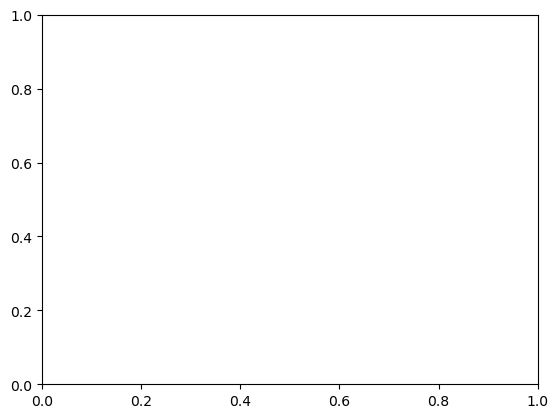

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches

fig, ax = plt.subplots()
h = 0.1
hx = 0.1
# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z = solgrad3

# Plot the surface.
surf = ax.pcolor(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Create a Rectangle patch
rect = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
hx = 0.1
# Add a grid
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.5)
major_ticks = np.arange(0., 1.+hx, hx)
minor_ticks = np.arange(0., 1.+hx, hx)

plt.xticks(major_ticks)
plt.yticks(major_ticks)

plt.show()